In [1]:
import pandas as pd
import tensorflow as tf
from keras.preprocessing import text, sequence
import numpy as np
from keras.layers import Input, SpatialDropout1D,Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, \
                            CuDNNGRU, GRU, Bidirectional, LSTM, Dense, Embedding, concatenate, Embedding, \
                            Flatten, Activation, BatchNormalization, regularizers, Conv1D, Conv2D, MaxPooling2D
from keras.constraints import max_norm

from keras.initializers import Orthogonal
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LambdaCallback, Callback, LearningRateScheduler
import keras.backend as K
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import os
import pickle
import gc; gc.enable()
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.corpus import stopwords                
from nltk.stem.snowball import RussianStemmer
from scipy.stats import boxcox
import re
#from tqdm import tqdm

E:\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Check GPU Availability

In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13424623503592292352
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3174131302
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12561443380628681287
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

### Preprocess Training and Testing Data

* > train.csv, test.csv, train_jpg.zip, test_jpg.zip: Download from kaggle competition website
* > aggregated_features, self trained wordvec: https://drive.google.com/drive/folders/1yO_W-m0fF_PludrnScdgyTGsPFoDsA6_?usp=sharing

In [3]:
# you could download it on the google drive we shared. More columns than in public kernel
agg_features_path = 'aggregated_features.csv'
train_data_path = 'train.csv'
test_data_path = 'test.csv'
embedding_file = 'avito_description_300.w2v' #'cc.ru.300.vec'
title_embedding_file = 'avito_title_100_ver2.w2v'
seed = 411
rnn_train_epochs = 10
batch_size=2 # 32 or 64 is good (too huge for my PC), 128 is worse in the past experiments
cpu_count=3

In [4]:
agg_features = pd.read_csv(agg_features_path)
agg_cols = list(agg_features.columns)[1:]

In [5]:
train = pd.read_csv('train.csv', parse_dates=['activation_date']) \
          .sort_values('activation_date') \
          .reset_index(drop=True)
    
test = pd.read_csv('test.csv', parse_dates=['activation_date'])

In [6]:
train = train.merge(agg_features, on='user_id', how='left')
test = test.merge(agg_features, on='user_id', how='left')
del agg_features; gc.collect()

86

In [7]:
# merge to faciliate data cleaning and transformation
train_len = train.shape[0]
train_y = train.deal_probability.values

train.drop('deal_probability', axis=1, inplace=True)
all_features = pd.concat([train, test]).reset_index(drop=True)

del train, test; gc.collect()

14

#### Clean data

In [8]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])

In [9]:
stemmer = RussianStemmer(ignore_stopwords=False)
'''
def clean_text(txt):
    words = str(txt).lower().strip().split(" \t\r.,!?^+-*/@~:;/\\\"\'&{}[]()#$%") #str(txt).split(" ") #
    words = [stemmer.stem(wrd) for wrd in words \
                if wrd not in stopwords.words('russian') and len(wrd) > 1]
    txt = u" ".join(words)
    return txt
'''
def clean_text(txt):
    return u" ".join([stemmer.stem(re.sub(r'\b\d+\b', '', wrd)) for wrd in str(txt).lower().strip().split(string.punctuation)
                         if wrd not in stopwords.words('russian')])

In [10]:
all_features['description'].fillna('unknowndescription', inplace=True)
all_features['description'] = [clean_text(txt) for txt in all_features['description'].values] # clean text

all_features['title'].fillna('unknowntitle', inplace=True)
all_features['title'] = [clean_text(txt) for txt in all_features['title'].values]

all_features['weekday'] = pd.to_datetime(all_features['activation_date']).dt.day

for col in ['description', 'title']:
    all_features['num_words_' + col] = all_features[col].apply(lambda comment: len(comment.split()))
    all_features['num_unique_words_' + col] = all_features[col].apply(lambda comment: len(set(w for w in comment.split())))

all_features['words_vs_unique_title'] = all_features['num_unique_words_title'] / all_features['num_words_title'] * 100
all_features['words_vs_unique_description'] = all_features['num_unique_words_description'] / all_features['num_words_description'] * 100
all_features['words_vs_unique_description'] = all_features['words_vs_unique_description'].fillna(0.)

all_features['city'] = all_features['region'] + '_' + all_features['city'] # city is repeated in different region
all_features['num_desc_punct'] = all_features['description'].apply(lambda x: count(x, set(string.punctuation)))

for col in agg_cols:
    all_features[col].fillna(-1, inplace=True)

for col in ['price', 'image_top_1']:
    all_features[col].fillna(-1, inplace=True)

for col in ['param_1', 'param_2', 'param_3']:
    all_features[col].fillna('unknwonparam', inplace=True)
    
for col in ['image']:
    all_features[col].fillna('no-image', inplace=True)

In [11]:
all_features.isnull().sum()

item_id                           0
user_id                           0
region                            0
city                              0
parent_category_name              0
category_name                     0
param_1                           0
param_2                           0
param_3                           0
title                             0
description                       0
price                             0
item_seq_number                   0
activation_date                   0
user_type                         0
image                             0
image_top_1                       0
avg_days_up_user                  0
avg_times_up_user                 0
med_days_up_user                  0
med_times_up_user                 0
n_user_items                      0
weekday                           0
num_words_description             0
num_unique_words_description      0
num_words_title                   0
num_unique_words_title            0
words_vs_unique_title       

#### Transform data

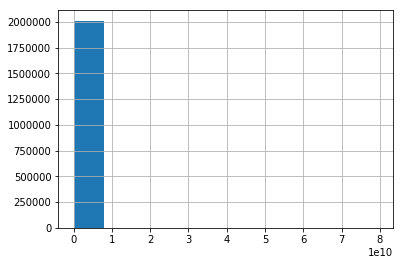

In [12]:
all_features.price.hist()

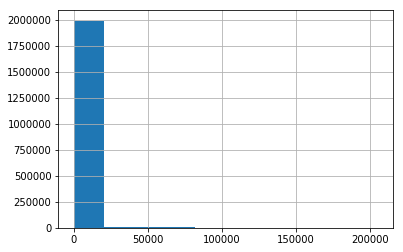

In [13]:
all_features.item_seq_number.hist()

> Since price and item seq number are highly skewed, we'll transform it into more normal like by using boxcox (more robust to outliers compared to np.log1p)

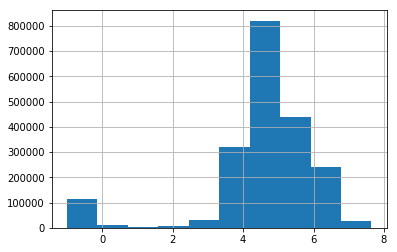

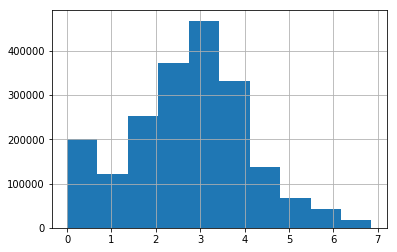

In [14]:
for col in ['price', 'item_seq_number']:
    select_filter = all_features[col] > 0
    all_features.loc[select_filter, col], _ = boxcox(all_features.loc[select_filter, col])
    all_features[col].hist()
    plt.show()

In [15]:
all_features.columns.tolist()

['item_id',
 'user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'param_2',
 'param_3',
 'title',
 'description',
 'price',
 'item_seq_number',
 'activation_date',
 'user_type',
 'image',
 'image_top_1',
 'avg_days_up_user',
 'avg_times_up_user',
 'med_days_up_user',
 'med_times_up_user',
 'n_user_items',
 'weekday',
 'num_words_description',
 'num_unique_words_description',
 'num_words_title',
 'num_unique_words_title',
 'words_vs_unique_title',
 'words_vs_unique_description',
 'num_desc_punct']

In [16]:
target = 'deal_probability'
numerical = [
    'weekday', 'num_words_title', 'num_words_description',
    'num_unique_words_title', 'num_unique_words_description',
    'words_vs_unique_title', 'words_vs_unique_description',
    'num_desc_punct', 'avg_times_up_user', 'avg_days_up_user', 
    'med_times_up_user', 'med_days_up_user', 'n_user_items', 
    'price', 'item_seq_number'
]

categorical = [
    'image_top_1', 'param_1', 'param_2', 'param_3', 
    'city', 'region', 'category_name', 'parent_category_name', 'user_type'
]

features = numerical+categorical

In [17]:
# label encode categorical data
from sklearn.preprocessing import LabelEncoder

for feature in categorical:
    print('Transforming {}...'.format(feature))
    encoder = LabelEncoder()
    all_features.loc[:, feature] = encoder.fit_transform(all_features[feature].astype(str))

Transforming image_top_1...
Transforming param_1...
Transforming param_2...
Transforming param_3...
Transforming city...
Transforming region...
Transforming category_name...
Transforming parent_category_name...
Transforming user_type...


In [18]:
all_features.loc[:, numerical] = all_features[numerical].fillna(0)

In [19]:
all_features[numerical].isnull().sum()

weekday                         0
num_words_title                 0
num_words_description           0
num_unique_words_title          0
num_unique_words_description    0
words_vs_unique_title           0
words_vs_unique_description     0
num_desc_punct                  0
avg_times_up_user               0
avg_days_up_user                0
med_times_up_user               0
med_days_up_user                0
n_user_items                    0
price                           0
item_seq_number                 0
dtype: int64

In [20]:
# standardize numerical data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_features.loc[:, numerical] = scaler.fit_transform(all_features[numerical].values)

#### Prepare  pre-trained embeddings and text

In [21]:
max_features = 500000
maxlen = 150
embed_size = 300

title_max_features = 200000
title_maxlen = 80
title_embed_size = 100

In [22]:
from gensim.models import word2vec

def get_embed_matrix(emb_file, texts, max_feat_num, max_len, emb_size):

    print('getting embeddings')
    embeddings_index = word2vec.Word2Vec.load(emb_file)
    
    print('fitting tokenizer')
    tokenizer = text.Tokenizer(num_words=max_feat_num)
    tokenizer.fit_on_texts(texts)
    
    print('convert to sequences')
    texts = tokenizer.texts_to_sequences(texts)

    print('padding')
    texts = sequence.pad_sequences(texts, maxlen=max_len)

    word_index = tokenizer.word_index
    nb_words = min(max_feat_num, len(word_index))
    embedding_matrix = np.zeros((nb_words, emb_size))
    for word, i in word_index.items():
        if i >= max_feat_num: continue
        try:
            embedding_vector = embeddings_index[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
      
    
    return {
        'text': texts,
        'emb_matrix': embedding_matrix,
        'nb_words': nb_words
    }

E:\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [23]:
desc_embed_info = get_embed_matrix(embedding_file, 
                                   all_features.description.values, 
                                   max_features, 
                                   maxlen, 
                                   embed_size)

title_embed_info = get_embed_matrix(title_embedding_file, 
                                    all_features.title.values, 
                                    title_max_features, 
                                    title_maxlen, 
                                    title_embed_size)

getting embeddings
fitting tokenizer
convert to sequences
padding


E:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


getting embeddings
fitting tokenizer
convert to sequences
padding


In [42]:
embed_dump = {
    'desc_embed_info': desc_embed_info,
    'title_embed_info': title_embed_info
}

import pickle
pickle.dump(embed_dump, open('rnn_embed.pkl', 'wb'))

In [24]:
print('setup max info for embedding in categorical variables')
max_info = dict((col, all_features[col].max()+1) for col in categorical)

setup max info for embedding in categorical variables


### Build RNN Model

In [25]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [26]:
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        print(input_shape)
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [27]:
def clip_rmse(true, prediction):
    return np.sqrt(metrics.mean_squared_error(true, np.clip(prediction, 0., 1.)))
    
class NBatchEvalLogger(Callback):
    def __init__(self, display, val_X, val_y, save_path=None, save_start=1000):
        self.step = 0
        self.display = display
        self.val_X = val_X
        self.val_y = val_y
        self.best_loss = None
        self.save_path = save_path
        self.save_start = save_start
        self.record_count = 0
        
    def on_batch_end(self, batch, logs={}):
        self.step += 1
        if self.step % self.display == 0 and self.step >= self.save_start:
            #loss, metric = self.model.evaluate(self.val_X, self.val_y, batch_size=128, verbose=1)
            prediction = self.model.predict(self.val_X, batch_size=128, verbose=0)
            loss = clip_rmse(self.val_y, prediction)
            
            if self.best_loss is None:
                self.best_loss = loss
            else:
                if loss < self.best_loss:
                    self.best_loss = loss
                    if self.save_path is not None:
                        self.model.save(self.save_path, overwrite=True)
                        self.record_count += 1
                    
            print('\rstep: {} val loss={:.5f}, best loss={:.5f}'.format(self.step, loss, self.best_loss))

In [28]:
import keras
from copy import deepcopy as cp
import os
from zipfile import ZipFile
import cv2
import numpy as np
import pandas as pd
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet50 import preprocess_input
import concurrent.futures

class DataGenerator(keras.utils.Sequence):
    #'Generates data for Keras'
    def __init__(self, list_IDs, X, y, img_arch, img_path, batch_size=32, shuffle=True, is_train=True):
        #'Initialization'
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.img_path = img_path
        self.is_train = is_train
        self.on_epoch_end()
        self.zipped = ZipFile(img_arch)
        print('file names:\n', self.zipped.namelist()[1:10], '\n...')
        self.img_path = img_path
        
    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        #'Generate one batch of data'
        # Generate indexes of the batch
        start = index*self.batch_size
        end = min((index+1)*self.batch_size, len(self.indexes))
        indexes = self.indexes[start: end]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        #'Updates indexes after each epoch'
        self.indexes = cp(list(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def load_img_from_zipped(self, img_id):
        
        invalid_img_ids = ['4f029e2a00e892aa2cac27d98b52ef8b13d91471f613c8d3c38e3f29d4da0b0c', 
                           '8513a91e55670c709069b5f85e12a59095b802877715903abef16b7a6f306e58', 
                           '60d310a42e87cdf799afcd89dc1b11ae3fdc3d0233747ec7ef78d82c87002e83', 
                           'b98b291bd04c3d92165ca515e00468fd9756af9a8f1df42505deed1dcfb5d7ae']
        
        try:
            if img_id in invalid_img_ids or img_id == 'no-image':
                imz = None
            else:
                exfile = self.zipped.read(self.img_path+img_id+'.jpg')
                arr = np.frombuffer(exfile, np.uint8)
                imz = cv2.imdecode(arr, flags=cv2.IMREAD_UNCHANGED)
                imz = cv2.resize(imz, (224,224), interpolation=cv2.INTER_AREA)
        except:
            print(img_id, ' is invalid')
            imz = None
            
        if imz is None:
            imz = np.zeros((1, 224, 224, 3))
        else:
            imz = img_to_array(imz)
            imz = np.expand_dims(imz, axis=0)
            
        imz = preprocess_input(imz) # adjust to mean of rgb to some value
            
        return imz

    def parallel_load_imgs(self, img_ids):
        global cpu_count
        '''
        with concurrent.futures.ThreadPoolExecutor(max_workers=cpu_count) as executor:
            # Process the list of files, but split the work across the process pool to use all CPUs!
            imgs = np.concatenate([img for img in executor.map(self.load_img_from_zipped, img_ids, chunksize=len(img_ids)//3)])    
        '''
        imgs = np.concatenate([self.load_img_from_zipped(imgid) for imgid in img_ids])    
        
        return imgs
    
    def __data_generation(self, list_IDs_temp):
        #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        # Generate data
        X = dict((col, self.X.loc[list_IDs_temp, col].values) for col in features)
        X['desc'] = desc_embed_info['text'][list_IDs_temp,:]
        X['title'] = title_embed_info['text'][list_IDs_temp,:]
        X['imgs'] = self.parallel_load_imgs(self.X.loc[list_IDs_temp, 'image'].values)
        
        if self.is_train:
            y = cp(self.y[list_IDs_temp])
            return X, y
        else:
            return X

In [29]:
# 'train_jpg.zip', 'data/competition_files/train_jpg/', 
# debug use
'''
zipped = ZipFile('train_jpg.zip')
print(zipped.namelist()[1:10])

img_id = '2809fd6afd6d3cae4dd4ad93a7f905a0db32292f4df4b3f19fa5492e08cbfd90'
target_size=(224,224)
try:
    exfile = zipped.read('data/competition_files/train_jpg/'+img_id+'.jpg')
    arr = np.frombuffer(exfile, np.uint8)
    imz = cv2.imdecode(arr, flags=cv2.IMREAD_UNCHANGED)
    imz = cv2.resize(imz, target_size, interpolation=cv2.INTER_AREA)
except:
    print(img_id, ' is invalid')
    imz = None
imz
'''

"\nzipped = ZipFile('train_jpg.zip')\nprint(zipped.namelist()[1:10])\n\nimg_id = '2809fd6afd6d3cae4dd4ad93a7f905a0db32292f4df4b3f19fa5492e08cbfd90'\ntarget_size=(224,224)\ntry:\n    exfile = zipped.read('data/competition_files/train_jpg/'+img_id+'.jpg')\n    arr = np.frombuffer(exfile, np.uint8)\n    imz = cv2.imdecode(arr, flags=cv2.IMREAD_UNCHANGED)\n    imz = cv2.resize(imz, target_size, interpolation=cv2.INTER_AREA)\nexcept:\n    print(img_id, ' is invalid')\n    imz = None\nimz\n"

In [30]:
def build_model(X, categorical_features, numerical_features):
    
    # non-cat features
    non_cat_inputs = []
    for col in numerical_features:
        f = Input(shape=[1], name=col)
        non_cat_inputs.append(f)
        
    # cat features
    cat_inputs = []
    cat_embeds = []
    for col in categorical_features:
        f = Input(shape=[1], name=col)
        embed_dim = max_info[col].max()
        if max_info[col] > 10:
            reduced_dim = 10
        else:
            reduced_dim = 1
        embed_f = Embedding(embed_dim, reduced_dim)(f)
        flatten_f = Flatten()(embed_f)
        cat_inputs.append(f)
        cat_embeds.append(flatten_f)
      
    # text features: architecture of text to try here!!!
    
    # description
    text_inp = Input(shape = (maxlen, ), name='desc')
    text_emb = Embedding(desc_embed_info['nb_words'], embed_size, weights = [desc_embed_info['emb_matrix']],
                    input_length = maxlen, trainable = False)(text_inp)
    text_emb = SpatialDropout1D(0.3)(text_emb)
    text_gru = Bidirectional(CuDNNGRU(128, return_sequences = True))(text_emb)
    text_gru = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(text_gru)
    text_gru_avg = GlobalAveragePooling1D()(text_gru)
    text_gru_max = GlobalMaxPooling1D()(text_gru)
    text_gru = concatenate([text_gru_avg, text_gru_max]) 
    text_gru = Dropout(0.1)(text_gru)
    
    # title
    title_inp = Input(shape = (title_maxlen, ), name='title')
    title_emb = Embedding(title_embed_info['nb_words'], title_embed_size, weights = [title_embed_info['emb_matrix']],
                    input_length = title_maxlen, trainable = False)(title_inp)
    title_emb = SpatialDropout1D(0.1)(title_emb)
    title_gru = Bidirectional(CuDNNGRU(32, return_sequences = True))(title_emb)
    title_gru = Conv1D(16, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(title_gru)
    title_gru_avg = GlobalAveragePooling1D()(title_gru)
    title_gru_max = GlobalMaxPooling1D()(title_gru)
    title_gru = concatenate([title_gru_avg, title_gru_max]) 
    title_gru = Dropout(0.1)(title_gru)
    
    # add image architecture
    # reference: https://keras.io/getting-started/functional-api-guide/#more-examples, Visual question answering model
    img_inp = Input(shape = (224, 224, 3 ), name='imgs')
    img_ch = Conv2D(64, (3, 3), activation='relu', padding='same', W_constraint=max_norm(3))(img_inp)
    img_ch = Conv2D(64, (3, 3), activation='relu')(img_ch)
    img_ch = MaxPooling2D((2, 2))(img_ch)
    '''
    img_ch = Conv2D(128, (3, 3), activation='relu', padding='same', W_constraint=max_norm(3))(img_ch)
    img_ch = Conv2D(128, (3, 3), activation='relu')(img_ch)
    img_ch = MaxPooling2D((2, 2))(img_ch)
    img_ch = Conv2D(256, (3, 3), activation='relu', padding='same', W_constraint=max_norm(3))(img_ch)
    img_ch = Conv2D(256, (3, 3), activation='relu')(img_ch)
    img_ch = Conv2D(256, (3, 3), activation='relu')(img_ch)
    img_ch = MaxPooling2D((2, 2))(img_ch)
    '''
    img_ch = Flatten()(img_ch)

    # merge each branch: non-cat, cat, text, img
    concat_main = non_cat_inputs+cat_embeds+[text_gru, title_gru, img_ch]
    main = concatenate(concat_main)
    main = BatchNormalization()(main)
    main = Dropout(0.1)(main)
    main = BatchNormalization()(Dense(512, activation='relu')(main))
    main = Dropout(0.1)(main)
    main = BatchNormalization()(Dense(64, activation='relu')(main))
    out = Dense(1, activation = "sigmoid")(main)

    concat_input = non_cat_inputs+cat_inputs+[text_inp, title_inp, img_inp]
    model = Model(concat_input, out)
    model.regularizers = [regularizers.l2(0.0001)]
    model.compile(optimizer = Adam(lr=0.001), loss = root_mean_squared_error,
                  metrics =[root_mean_squared_error])
    model.summary()
    return model

### Training

In [31]:
from sklearn.model_selection import KFold
import warnings; warnings.filterwarnings('ignore') 

In [32]:
train_indices = np.arange(0, train_len)
test_indices = np.arange(train_len, all_features.shape[0])

In [33]:
from keras_tqdm import TQDMNotebookCallback
from ipywidgets import IntProgress

In [34]:
start_fold = 0 # <= 0 for invalid, train from fold 1, > 0: used to train from fold=start_fold
resume_file_prefix = '0618_rnn' # whatever we like

In [35]:
if start_fold > 0:
    import pickle
    ret = pickle.load(open(resume_file_prefix+'_oof_val_pred', 'rb'))
    ret_test = pickle.load(open(resume_file_prefix+'_oof_test_pred', 'rb'))
    print(ret)
    print(ret_test)
else:
    ret = np.zeros((train_len,))
    ret_test = np.zeros((all_features.shape[0]-train_len,))

fold = 0    
for tr_ix, val_ix in KFold(5, shuffle=True, random_state=seed).split(train_indices):
    fold += 1
    
    if start_fold > 0 and fold < start_fold:
        continue
    else:
        pass
    
    model = build_model(all_features, categorical, numerical)
    file_path = "rnn_weights/model_self_train_with_image_fold_{}.hdf5".format(fold)
     
    # customized batch loader
    training_generator = DataGenerator(tr_ix, all_features, train_y, 
                                       'train_jpg.zip', 'data/competition_files/train_jpg/', 
                                       batch_size=batch_size, shuffle=True)
    validation_generator = DataGenerator(val_ix, all_features, train_y, 
                                         'train_jpg.zip', 'data/competition_files/train_jpg/', 
                                         batch_size=batch_size, shuffle=False)

    lr_schd = LearningRateScheduler(lambda epoch: 0.001*(0.2**(epoch//6)), verbose=1)
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", mode = "min", save_best_only = True, verbose = 1)
    history = model.fit_generator(generator=training_generator,
                                  validation_data=validation_generator,
                                  use_multiprocessing=False,
                                  workers=1, 
                                  epochs=rnn_train_epochs,
                                  verbose = 0, 
                                  callbacks = [lr_schd, check_point, TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
    
    
    # Predict val + test oofs
    model.load_weights(file_path) # load weight with best validation score
    
    del validation_generator
    validation_generator = DataGenerator(val_ix, all_features, None, 
                                         'train_jpg.zip', 'data/competition_files/train_jpg/', 
                                         batch_size=batch_size, shuffle=False, is_train=False)
    test_generator = DataGenerator(test_indices, all_features, None, 
                                   'test_jpg.zip', 'data/competition_files/test_jpg/',       
                                   batch_size=batch_size, shuffle=False, is_train=False)
    
    ret[val_ix] = model.predict_generator(validation_generator, use_multiprocessing=False, workers=1).reshape((len(val_ix),))
    ret_test += model.predict_generator(test_generator, use_multiprocessing=False, workers=1).reshape((ret_test.shape[0],))
    
    del model, history, training_generator, validation_generator, test_generator; gc.collect()
    
ret_test /= 5

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
desc (InputLayer)               (None, 150)          0                                            
__________________________________________________________________________________________________
title (InputLayer)              (None, 80)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 150, 300)     150000000   desc[0][0]                       
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 80, 100)     

                                                                 flatten_9[0][0]                  
                                                                 dropout_1[0][0]                  
                                                                 dropout_2[0][0]                  
                                                                 flatten_10[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 788791)       3155164     concatenate_3[0][0]              
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 788791)       0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          403861504   dropout_3[0][0]                  
__________

ResourceExhaustedError: OOM when allocating tensor with shape[788791,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/Variable_31/Assign = Assign[T=DT_FLOAT, _class=["loc:@training/Adam/Variable_31"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/Variable_31, training/Adam/zeros_31)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training/Adam/Variable_31/Assign', defined at:
  File "E:\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "E:\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "E:\Anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "E:\Anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "E:\Anaconda3\envs\tensorflow\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 759, in _run_callback
    ret = callback()
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-104f91fa3312>", line 39, in <module>
    callbacks = [lr_schd, check_point, TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 2080, in fit_generator
    self._make_train_function()
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 992, in _make_train_function
    loss=self.total_loss)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers.py", line 457, in get_updates
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers.py", line 457, in <listcomp>
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 695, in zeros
    return variable(v, dtype=dtype, name=name)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 396, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 235, in __init__
    constraint=constraint)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 381, in _init_from_args
    validate_shape=validate_shape).op
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\state_ops.py", line 281, in assign
    validate_shape=validate_shape)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 64, in assign
    use_locking=use_locking, name=name)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3290, in create_op
    op_def=op_def)
  File "E:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[788791,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/Variable_31/Assign = Assign[T=DT_FLOAT, _class=["loc:@training/Adam/Variable_31"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/Variable_31, training/Adam/zeros_31)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
# uncomment these to dump files if OOM (out-of-mem) happens
import pickle
pickle.dump(ret, open(resume_file_prefix+'_oof_val_pred', 'wb'))
pickle.dump(ret_test, open(resume_file_prefix+'_oof_test_pred', 'wb'))

In [ ]:
# public:  cv = .2220, lb = .2247 
# bigru-conv1d: cv =.2185 , lb = .2235
# bigru-attention: cv =.2186 , lb = .2235
# 2gru: lb: .2239
# self-trained wordvec: cv .217232, lb: .2229

### Generate OOFs and Submissions

In [ ]:
pd.DataFrame(data=ret, columns=['selftrained_bigru_conv1d_img_rnn_pred']).to_csv('selftrained_bigru_conv1d_img_rnn_oof_val_pred.csv', index=False)
pd.DataFrame(data=ret_test, columns=['selftrained_bigru_conv1d_img_rnn_pred']).to_csv('selftrained_bigru_conv1d_img_rnn_oof_test_pred.csv', index=False)

In [ ]:
subm = pd.read_csv('sample_submission.csv')
subm['deal_probability'] = np.clip(ret_test, 0, 1)
subm.to_csv('selftrained_bigru_conv1d_img_rnn_submission.csv', index=False)